## 1. Consolidated files in the unique DataFrame and show the total files extracted

In [10]:
import os
import sys

notebook_path = os.path.dirname(os.path.abspath("data_explorer.ipynb"))
sys.path.append(os.path.dirname(notebook_path))

from etl.utils.common import DefaultOutputFolder as dir
import pandas as pd

files = os.listdir(dir())
dfs = []

if not files: print("No files found in the output folder.")

for file in files:
    if file.endswith(".parquet"):
        df = pd.read_parquet(dir() + file)
        dfs.append(df)
    
allFiles = pd.concat(dfs, ignore_index=True)

# Ordering DataFrame by column name
allFiles = allFiles.sort_values(by=['extracted_at'], ascending=False)

# count the rows in dataframe
allFiles.shape[0]

2642

## 1.1 Data set sample, list 5 files

In [11]:
allFiles.head(3)

,code,codein,name,high,low,varBid,pctChange,bid,ask,timestamp,create_date,symbol,extracted_at
2036,EUR,BND,Euro/Dólar de Brunei,1.4575,1.4564,-0.0011,-0.08,1.4314,1.4814,1715270239,2024-05-09 12:57:19,EUR-BND,2024-05-09 15:58:02
1292,EUR,AUD,Euro/Dólar Australiano,1.6355,1.628,-0.0026,-0.16,1.6309,1.6311,1715270258,2024-05-09 12:57:38,EUR-AUD,2024-05-09 15:58:02
670,EUR,HUF,Euro/Florim Húngaro,389.425,387.555,-0.599,-0.15,387.596,388.596,1715270251,2024-05-09 12:57:31,EUR-HUF,2024-05-09 15:58:02


## 2. Change DataTypes and Reorder columns

In [12]:
# Change data types
df = allFiles.astype({'ask': float, 'bid': float, 'varBid': float, 'pctChange': float})

# Show the dataframe
df.head(3)


,code,codein,name,high,low,varBid,pctChange,bid,ask,timestamp,create_date,symbol,extracted_at
2036,EUR,BND,Euro/Dólar de Brunei,1.4575,1.4564,-0.0011,-0.08,1.4314,1.4814,1715270239,2024-05-09 12:57:19,EUR-BND,2024-05-09 15:58:02
1292,EUR,AUD,Euro/Dólar Australiano,1.6355,1.628,-0.0026,-0.16,1.6309,1.6311,1715270258,2024-05-09 12:57:38,EUR-AUD,2024-05-09 15:58:02
670,EUR,HUF,Euro/Florim Húngaro,389.425,387.555,-0.5990,-0.15,387.5960,388.5960,1715270251,2024-05-09 12:57:31,EUR-HUF,2024-05-09 15:58:02


## 3. Using SQL for Data Exploration
    3.1 What is the currency with the highest ask value?

In [13]:
from pandasql import sqldf

query = """
    SELECT symbol, name, max(ask) max_ask FROM df 
    where code = 'BRL' 
    group by symbol, name
    order by 3 desc limit 1
"""

newDf = sqldf(query, locals())

newDf



,symbol,name,max_ask
0,BRL-LBP,Real Brasileiro/Libra Libanesa,17391.0


    3.1 Sample Data

In [93]:
from pandasql import sqldf

query = """
    SELECT codein, name, max(ask) FROM df 
    group by 1,2
    order by 3 desc limit 10
"""

newDf = sqldf(query, locals())

newDf

,codein,name,max(ask)
0,BRL,Bitcoin/Real Brasileiro,345579.0
1,LBP,Euro/Libra Libanesa,96171.9
2,LBP,Dólar Americano/Libra Libanesa,89603.9
3,USD,Bitcoin/Dólar Americano,66527.0
4,EUR,Bitcoin/Euro,62431.5
5,IRR,Dólar Americano/Rial Iraniano,42125.0
6,ZWL,Dólar Americano/Dólar Zimbabuense,32208.0
7,VND,Euro/Dong Vietnamita,27718.0
8,VND,Dólar Americano/Dong Vietnamita,25455.0
9,LAK,Euro/Kip Laosiano,23157.0


## 4. Using SQL + Matplotlib for Data Viz
    4.1 What is the Average ask price by currency?

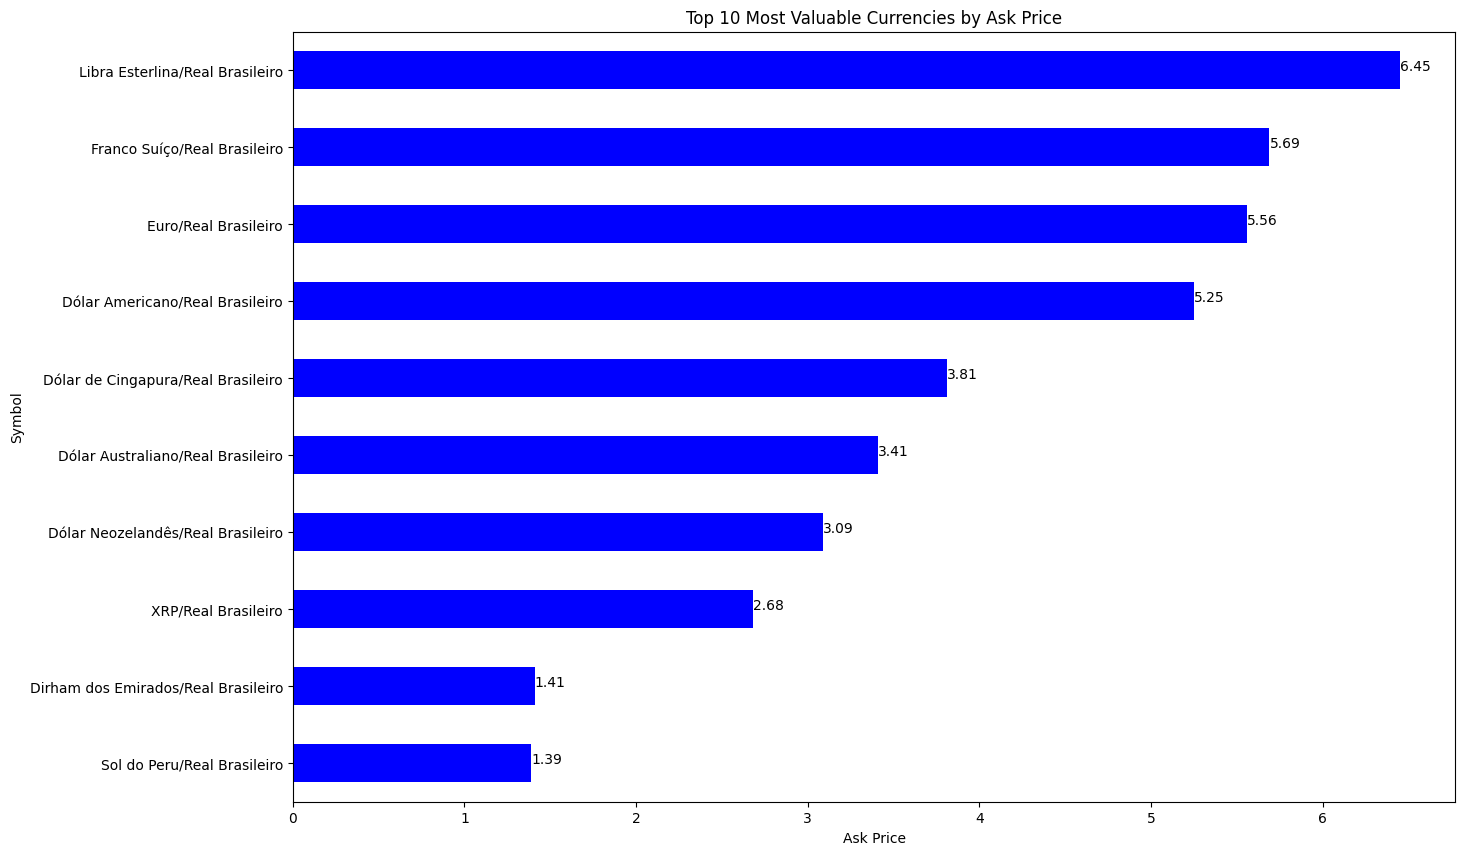

In [96]:

import matplotlib.pyplot as plt

query = """
    SELECT 
        name
        ,round(avg(ask),2) AvgAsk
    FROM df 
    where codein = 'BRL'
    and not code in ('BTC', 'ETH', 'LTC', 'DOGE')
    group by name
    order by avg(ask) desc limit 10
"""

newDf = sqldf(query, locals())
newDf.sort_values(by='AvgAsk', ascending=True, inplace=True)

AvgAskByCurrency = newDf.plot(
    kind='barh', x='name', y='AvgAsk', 
    figsize=(15, 10), 
    legend=False, 
    color='blue', title='Top 10 Most Valuable Currencies by Ask Price', xlabel='Ask Price', ylabel='Symbol')


# Adicionando rótulos aos dados
for index, value in enumerate(newDf['AvgAsk']):
    plt.text(value, index, str(value))

# Exibir o gráfico
plt.show()

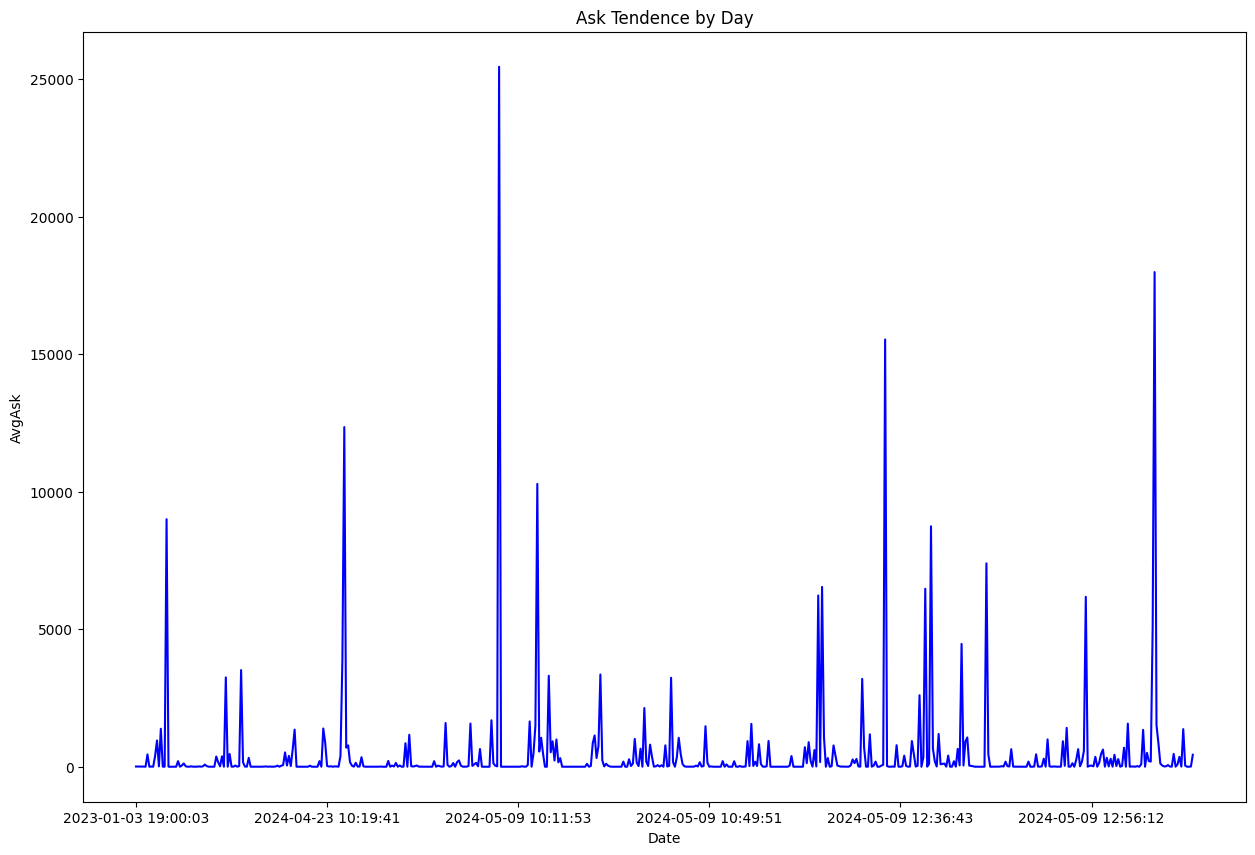

In [106]:

import matplotlib.pyplot as plt

query = """
    SELECT 
        create_date DT_REF
        ,round(min(ask),2) MinAks
        ,round(avg(ask),2) AvgAsk
        ,round(max(ask),2) MaxAsk
    FROM df 
    where not code in ('BTC', 'ETH', 'LTC', 'DOGE')
    group by 1
    order by 1 
"""

newDf = sqldf(query, locals())
newDf.sort_values(by='DT_REF', ascending=True, inplace=True)

cht = newDf.plot(
    kind='line', x='DT_REF', y='AvgAsk',
    figsize=(15, 10), 
    legend=False, 
    color='blue', title='Ask Tendence by Day', xlabel='Date', ylabel='AvgAsk')

#exibir o grafico
plt.show()